In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

from datetime import date

In [2]:
start = "2018-07-01"
# end = "2019-12-31"
end = date.today().strftime("%Y-%m-%d")
print(end)
print(date.today())

df = yf.download("AMZN", start, end)
df.tail()

2023-07-05
2023-07-05
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-06-27,128.630005,130.089996,127.550003,129.179993,129.179993,46801000
2023-06-28,128.940002,131.479996,128.440002,129.039993,129.039993,52149500
2023-06-29,128.770004,129.259995,127.260002,127.900002,127.900002,40761000
2023-06-30,129.470001,131.250000,128.949997,130.360001,130.360001,54310500
2023-07-03,130.820007,131.850006,130.070007,130.220001,130.220001,28264800


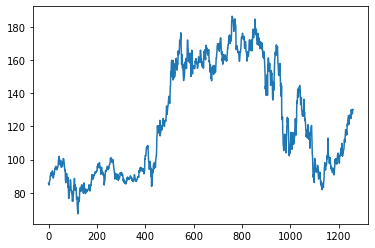

In [12]:
plt.plot(df.Close)

In [4]:
# ma - Moving Average, mean for a specified period of time, e.g 100 days, 200 days
ma100 = df.Close.rolling(100).mean()
ma100

Date
2009-12-31          NaN
2010-01-04          NaN
2010-01-05          NaN
2010-01-06          NaN
2010-01-07          NaN
                ...    
2019-12-23    59.201075
2019-12-24    59.401700
2019-12-26    59.643125
2019-12-27    59.875125
2019-12-30    60.106325
Name: Close, Length: 2516, dtype: float64

In [5]:
ma200 = df.Close.rolling(200).mean()
ma200

Date
2009-12-31          NaN
2010-01-04          NaN
2010-01-05          NaN
2010-01-06          NaN
2010-01-07          NaN
                ...    
2019-12-23    54.132313
2019-12-24    54.261513
2019-12-26    54.396763
2019-12-27    54.529350
2019-12-30    54.661100
Name: Close, Length: 2516, dtype: float64

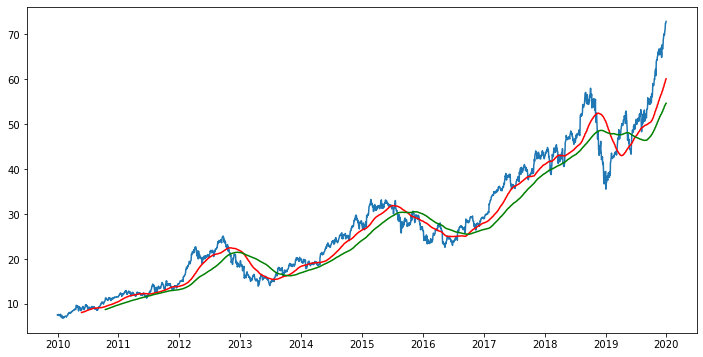

In [6]:
plt.figure(figsize = (12,6))
plt.plot(df.Close)
plt.plot(ma100, "r")
plt.plot(ma200, "g")

In [7]:
df.shape

(2516, 6)

In [3]:
# Split data into train and test
df = df.reset_index()
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1254,2023-06-27,128.630005,130.089996,127.550003,129.179993,129.179993,46801000
1255,2023-06-28,128.940002,131.479996,128.440002,129.039993,129.039993,52149500
1256,2023-06-29,128.770004,129.259995,127.260002,127.900002,127.900002,40761000
1257,2023-06-30,129.470001,131.250000,128.949997,130.360001,130.360001,54310500
1258,2023-07-03,130.820007,131.850006,130.070007,130.220001,130.220001,28264800


In [4]:
# 70% training data and 30% testing data
data_train = pd.DataFrame(df["Close"][0 : int(len(df) * 0.70)])
data_test = pd.DataFrame(df["Close"][int(len(df) * 0.70) : int(len(df))])

print(data_train.shape)
print(data_test.shape)

(881, 1)
(378, 1)


In [5]:
data_train.head()
data_train.tail()

,Close
876,171.037003
877,171.068497
878,169.669495
879,170.660995
880,169.201004


In [6]:
data_test.head()

,Close
881,168.644501
882,166.716995
883,170.404495
884,167.522003
885,164.356995


In [7]:
from sklearn.preprocessing import MinMaxScaler

In [8]:
scaler = MinMaxScaler(feature_range=(0,1))
data_train_array = scaler.fit_transform(data_train)
data_train_array

array([[0.15490172],
       [0.14659993],
       [0.14901678],
       [0.15358231],
       [0.16547361],
       [0.16717004],
       [0.17216698],
       [0.18959981],
       [0.19647322],
       [0.2004356 ],
       [0.20941595],
       [0.20899291],
       [0.1964481 ],
       [0.19675386],
       [0.19185324],
       [0.2032629 ],
       [0.217659  ],
       [0.19436641],
       [0.19824922],
       [0.18231168],
       [0.18156614],
       [0.18983015],
       [0.20539489],
       [0.2007707 ],
       [0.21101593],
       [0.21718573],
       [0.22725501],
       [0.23228135],
       [0.22716291],
       [0.23130956],
       [0.24113176],
       [0.22562147],
       [0.22725501],
       [0.22545396],
       [0.22314608],
       [0.22595657],
       [0.23495366],
       [0.23411589],
       [0.23515888],
       [0.24449522],
       [0.24664811],
       [0.27399109],
       [0.27578384],
       [0.28011058],
       [0.29133598],
       [0.27261723],
       [0.25732476],
       [0.254

In [9]:
data_train_array.shape

(881, 1)

In [10]:
x_train = []
y_train = []

for i in range(100, data_train_array.shape[0]):
    x_train.append(data_train_array[i - 100: i])
    y_train.append(data_train_array[i, 0])
    
# Convert to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [1]:
# ML Model
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential

In [ ]:
model = Sequential()

# First layer
model.add(LSTM(units=50, activation="relu", return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))

# Second layer
model.add(LSTM(units=60, activation="relu", return_sequences=True))
model.add(Dropout(0.3))

# Third layer
model.add(LSTM(units=80, activation="relu", return_sequences=True))
model.add(Dropout(0.4))

# Fourth layer
model.add(LSTM(units=120, activation="relu"))
model.add(Dropout(0.5))

# Connect all layers
model.add(Dense(units=1))

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer="adam", loss="mean_squared_error")
model.fit(x_train, y_train, epochs=50)

In [ ]:
model.save("s_trend_model")

In [ ]:
# Append the past 100 days to testing data
past_100_days = data_train.tail(100)
final_df = pd.concat([past_100_days, data_test], ignore_index=True)

In [ ]:
# Scale down testing data
input_data = scaler.fit_transform(final_df)
input_data
input_data.shape

In [ ]:
x_test = []
y_test = []

for i in range(100, input_data.shape[0]):
    x_test.append(input_data[i - 100: i])
    y_test.append(input_data[i, 0])
    
# Convert to numpy arrays
x_test, y_test = np.array(x_test), np.array(y_test)
print(x_test.shape)
print(y_test.shape)

In [ ]:
# Making Predictions
y_predicted = model.predict(x_test)
print(y_predicted.shape)
print(scaler.scale_)

# scale up
scale_factor = 1/0.02123255
y_predicted = y_predicted * scale_factor
y_test = y_test * scale_factor

plt.figure(figsize=(12,6))
plt.plot(y_test, "b", label="Original Price")
plt.plot(y_predicted, "r", label="Predicted Price")
plt.legend()
plt.xlabel("Year")
plt.ylabel("Price")
plt.show()